# Mô hình phân loại AST sử dụng Graph Neural Networks (GNN)

1. Cài đặt thư viện

In [1]:
!pip install torch torch_geometric networkx matplotlib scikit-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing inst

2. Import thư viện

In [2]:
import json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv
import networkx as nx
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

sys.path.append('/kaggle/input/py150k-1/')
import parse_python

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

TRAIN_DATA_PATH = '/kaggle/input/py150k-1/python100k_train.json'
EVAL_DATA_PATH = '/kaggle/input/py150k-1/python50k_eval.json'

print(f"Train data exists: {os.path.exists(TRAIN_DATA_PATH)}")
print(f"Eval data exists: {os.path.exists(EVAL_DATA_PATH)}")

Using device: cuda
Train data exists: True
Eval data exists: True


3. Phân tích dữ liệu

In [3]:
import json

TRAIN_DATA_PATH = '/kaggle/input/py150k-1/python100k_train.json'

# Đọc dòng đầu tiên và parse
with open(TRAIN_DATA_PATH, 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()

parsed = json.loads(first_line)
print("Parsed first sample, type =", type(parsed))

# Xác định AST và code
if isinstance(parsed, dict):
    ast_data = parsed.get('ast')
    code_data = parsed.get('code')
elif isinstance(parsed, list):
    # Toàn bộ list chính là AST
    ast_data = parsed
    code_data = None
else:
    raise ValueError("Không nhận diện được cấu trúc của sample")

# In thông tin AST
print("AST nodes:", len(ast_data))
print("Ví dụ node 31:", ast_data[31])

Parsed first sample, type = <class 'list'>
AST nodes: 116
Ví dụ node 31: {'type': 'NameLoad', 'value': 'Download'}


4. Chuyển đổi AST thành đồ thị và xử lý dữ liệu

In [4]:
# Hàm chuyển AST -> Graph cho PyG
def ast_to_graph(ast_data):
    """Chuyển đổi AST thành dạng đồ thị để sử dụng với PyTorch Geometric"""
    # Tạo danh sách các cạnh (có cả hai hướng)
    edge_list = []
    for parent_idx, node in enumerate(ast_data):
        for child_idx in node.get('children', []):
            if 0 <= child_idx < len(ast_data):  # Đảm bảo hợp lệ
                edge_list.append([parent_idx, child_idx])
                edge_list.append([child_idx, parent_idx])

    # Chuyển danh sách cạnh thành tensor
    if edge_list:
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.zeros((2, 0), dtype=torch.long)

    # Mã hoá node type thành chỉ số và convert sang float
    types = [node['type'] for node in ast_data]
    type2idx = {t: i for i, t in enumerate(sorted(set(types)))}
    x = torch.tensor([type2idx[t] for t in types], dtype=torch.float).unsqueeze(1)

    return Data(x=x, edge_index=edge_index)

# Hàm load và tiền xử lý dữ liệu
def load_and_process_data(path, max_samples=20000):
    graphs = []
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, total=max_samples, desc=f"Loading {path}")):
            if i >= max_samples:
                break
            try:
                sample = json.loads(line)
                ast_data = sample if isinstance(sample, list) else sample.get('ast', [])
                if len(ast_data) < 5:
                    continue
                g = ast_to_graph(ast_data)
                # Gán nhãn theo kích thước AST
                size = len(ast_data)
                label = 0 if size < 20 else (1 if size < 50 else 2)
                g.y = torch.tensor([label], dtype=torch.long)
                graphs.append(g)
            except Exception as e:
                print(f"Error at line {i}: {e}")
    return graphs

# Tạo tập nhỏ để kiểm thử
train_graphs = load_and_process_data(TRAIN_DATA_PATH, max_samples=20000)
eval_graphs  = load_and_process_data(EVAL_DATA_PATH,  max_samples=4000)

# In thống kê cơ bản
import numpy as np

def print_stats(graphs, name):
    nodes = [g.num_nodes for g in graphs]
    edges = [g.edge_index.size(1) // 2 for g in graphs]
    labels = [g.y.item() for g in graphs]
    print(f"{name}:")
    print(f"  Số graphs: {len(graphs)}")
    print(f"  Trung bình nodes: {np.mean(nodes):.2f}, edges: {np.mean(edges):.2f}")
    print(f"  Phân bố labels: {np.bincount(labels)}\n")

print_stats(train_graphs, "Train graphs")
print_stats(eval_graphs,  "Eval graphs")

Loading /kaggle/input/py150k-1/python100k_train.json: 100%|██████████| 20000/20000 [00:57<00:00, 350.09it/s]
Loading /kaggle/input/py150k-1/python50k_eval.json: 100%|██████████| 4000/4000 [00:10<00:00, 394.99it/s]


Train graphs:
  Số graphs: 19615
  Trung bình nodes: 625.68, edges: 624.68
  Phân bố labels: [  872  2789 15954]

Eval graphs:
  Số graphs: 3915
  Trung bình nodes: 534.08, edges: 533.08
  Phân bố labels: [ 187  914 2814]



5. Cân bằng dữ liệu


In [5]:
import random

# Hàm cân bằng dữ liệu
def balance_dataset(graphs, target_counts=[700, 700, 700]):
    """Cân bằng dữ liệu bằng cách over/under-sampling"""
    label_to_graphs = {0: [], 1: [], 2: []}
    for g in graphs:
        label = g.y.item()
        label_to_graphs[label].append(g)
    
    balanced_graphs = []
    for label, target in enumerate(target_counts):
        graphs_with_label = label_to_graphs[label]
        
        if len(graphs_with_label) == 0:
            continue
        
        # Over-sampling nếu thiếu mẫu
        if len(graphs_with_label) < target:
            # Lặp lại mẫu nếu cần
            balanced_graphs.extend(graphs_with_label * (target // len(graphs_with_label)))
            # Thêm mẫu còn thiếu
            remainder = target % len(graphs_with_label)
            if remainder > 0:
                balanced_graphs.extend(random.sample(graphs_with_label, remainder))
        # Under-sampling nếu thừa mẫu
        else:
            balanced_graphs.extend(random.sample(graphs_with_label, target))
    
    random.shuffle(balanced_graphs)
    return balanced_graphs

# Cân bằng dữ liệu train
balanced_train_graphs = balance_dataset(train_graphs)
print_stats(balanced_train_graphs, "Balanced train graphs")

Balanced train graphs:
  Số graphs: 2100
  Trung bình nodes: 256.38, edges: 255.38
  Phân bố labels: [700 700 700]



6. Định nghĩa mô hình GNN

In [6]:
class ImprovedGNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=3, dropout=0.3):
        super(ImprovedGNNModel, self).__init__()
        
        # Lớp GNN đầu tiên - sử dụng Graph Convolutional Network
        self.conv1 = GCNConv(input_dim, hidden_dim)
        
        # Lớp GNN thứ hai
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Lớp GNN thứ ba - thêm layer bổ sung
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        
        # Lớp GNN thứ tư với Graph Attention Network để chú ý vào các phần quan trọng
        self.gat = GATv2Conv(hidden_dim, hidden_dim // 4, heads=4)
        
        # Layer normalization
        self.norm1 = torch.nn.LayerNorm(hidden_dim)
        self.norm2 = torch.nn.LayerNorm(hidden_dim)
        self.norm3 = torch.nn.LayerNorm(hidden_dim)
        
        # Lớp fully connected cho phân loại
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        
        # Dropout để giảm overfitting
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Áp dụng lớp GNN đầu tiên
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Áp dụng lớp GNN thứ hai
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Áp dụng lớp GNN thứ ba
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.dropout(x)

        if self.training:
            # Trong quá trình training, không cần lưu attention weights
            x = self.gat(x, edge_index)
            self.attention_weights = None
        else:
            # Trong quá trình evaluation, lưu attention weights
            x, (_, att_weights) = self.gat(x, edge_index, return_attention_weights=True)
            self.attention_weights = att_weights
            
        x = F.relu(x)
        x = self.dropout(x)
        
        # Áp dụng lớp GNN thứ tư với attention
        x = self.gat(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Tính toán biểu diễn đồ thị bằng cách lấy trung bình của tất cả các node
        x = torch.mean(x, dim=0, keepdim=True)
        
        # Phân loại với nhiều lớp fully connected
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Chia tập train thành train và validation
train_graphs, val_graphs = train_test_split(balanced_train_graphs, test_size=0.2, random_state=42)

# Tạo DataLoader cho việc huấn luyện batch
batch_size = 32
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size)
test_loader = DataLoader(eval_graphs, batch_size=batch_size)

# Khởi tạo mô hình GNN cải tiến
if train_graphs:
    input_dim = train_graphs[0].x.size(1)  # Số loại node (feature dimension)
    hidden_dim = 128  # Tăng kích thước hidden layer
    output_dim = 3  # Số lớp phân loại (AST nhỏ, trung bình, lớn)
    
    model = ImprovedGNNModel(input_dim, hidden_dim, output_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Learning rate thấp hơn
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-5
    )
    
    print(f"Model initialized with input dim: {input_dim}, output dim: {output_dim}")
    print(model)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Model initialized with input dim: 1, output dim: 3
ImprovedGNNModel(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (gat): GATv2Conv(128, 32, heads=4)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


7. Huấn luyện và đánh giá mô hình

Starting training...


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.39it/s]


Epoch: 001, Train Loss: 1.0466, Val Acc: 0.5810, Val Precision: 0.5884, Val Recall: 0.5810, Val F1: 0.5085


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.49it/s]


Epoch: 002, Train Loss: 0.6795, Val Acc: 0.6929, Val Precision: 0.6892, Val Recall: 0.6929, Val F1: 0.6640


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]


Epoch: 003, Train Loss: 0.6486, Val Acc: 0.8071, Val Precision: 0.8177, Val Recall: 0.8071, Val F1: 0.7992


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch: 004, Train Loss: 0.5507, Val Acc: 0.7738, Val Precision: 0.8033, Val Recall: 0.7738, Val F1: 0.7703


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Epoch: 005, Train Loss: 0.5463, Val Acc: 0.8310, Val Precision: 0.8321, Val Recall: 0.8310, Val F1: 0.8297


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Epoch: 006, Train Loss: 0.5248, Val Acc: 0.7976, Val Precision: 0.8168, Val Recall: 0.7976, Val F1: 0.7937


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.62it/s]


Epoch: 007, Train Loss: 0.4723, Val Acc: 0.7952, Val Precision: 0.8136, Val Recall: 0.7952, Val F1: 0.7925


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch: 008, Train Loss: 0.4732, Val Acc: 0.8167, Val Precision: 0.8233, Val Recall: 0.8167, Val F1: 0.8160


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch: 009, Train Loss: 0.4932, Val Acc: 0.7548, Val Precision: 0.7912, Val Recall: 0.7548, Val F1: 0.7490


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]


Epoch: 010, Train Loss: 0.4945, Val Acc: 0.8024, Val Precision: 0.8093, Val Recall: 0.8024, Val F1: 0.8001


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]


Epoch: 011, Train Loss: 0.4933, Val Acc: 0.8000, Val Precision: 0.8131, Val Recall: 0.8000, Val F1: 0.7977


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.52it/s]


Epoch: 012, Train Loss: 0.4432, Val Acc: 0.8167, Val Precision: 0.8244, Val Recall: 0.8167, Val F1: 0.8120


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]


Epoch: 013, Train Loss: 0.4487, Val Acc: 0.8071, Val Precision: 0.8177, Val Recall: 0.8071, Val F1: 0.8052


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Epoch: 014, Train Loss: 0.4467, Val Acc: 0.8119, Val Precision: 0.8231, Val Recall: 0.8119, Val F1: 0.8114


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch: 015, Train Loss: 0.4381, Val Acc: 0.7952, Val Precision: 0.8068, Val Recall: 0.7952, Val F1: 0.7904


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]


Epoch: 016, Train Loss: 0.4354, Val Acc: 0.8119, Val Precision: 0.8189, Val Recall: 0.8119, Val F1: 0.8104


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch: 017, Train Loss: 0.4434, Val Acc: 0.8095, Val Precision: 0.8161, Val Recall: 0.8095, Val F1: 0.8055


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.61it/s]


Epoch: 018, Train Loss: 0.4227, Val Acc: 0.8024, Val Precision: 0.8128, Val Recall: 0.8024, Val F1: 0.7981


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch: 019, Train Loss: 0.4314, Val Acc: 0.8048, Val Precision: 0.8129, Val Recall: 0.8048, Val F1: 0.8013


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch: 020, Train Loss: 0.4260, Val Acc: 0.7976, Val Precision: 0.8102, Val Recall: 0.7976, Val F1: 0.7932
Early stopping at epoch 20


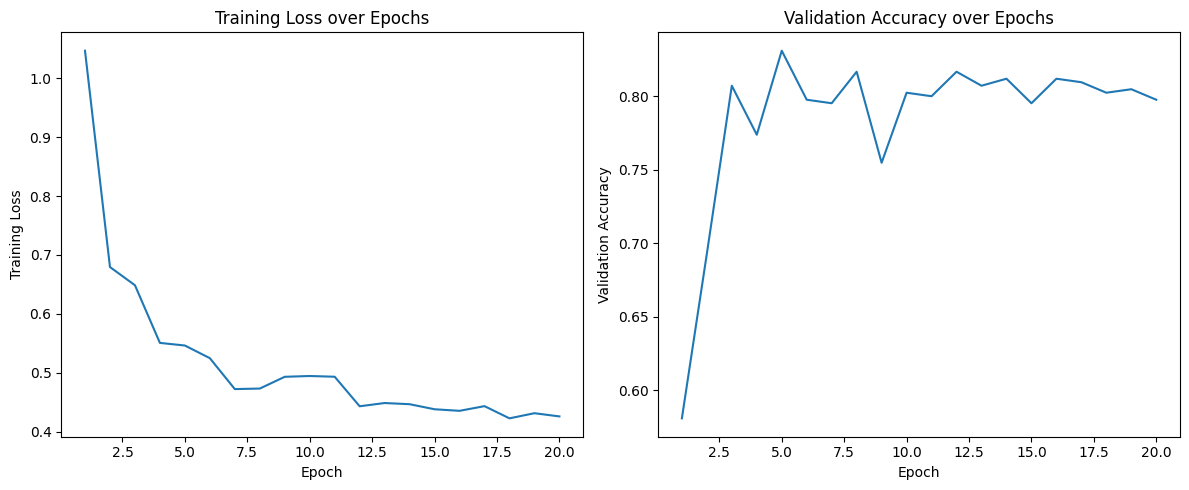

/tmp/ipykernel_19/758395773.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gnn_model.pt'))
Evaluating: 100%|██████████| 123/123

Test Accuracy: 0.8350, Test Precision: 0.8813, Test Recall: 0.8350, Test F1: 0.8466


In [7]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for data in tqdm(train_loader, desc="Training"):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Xử lý từng đồ thị trong batch riêng biệt
        batch_losses = []
        for i in range(data.num_graphs):
            # Lấy subgraph cho mỗi đồ thị trong batch
            mask = data.batch == i
            sub_data = Data(
                x=data.x[mask],
                edge_index=data.edge_index[:, (data.edge_index[0] >= mask.nonzero()[0][0]) & 
                                         (data.edge_index[0] <= mask.nonzero()[-1][0]) &
                                         (data.edge_index[1] >= mask.nonzero()[0][0]) & 
                                         (data.edge_index[1] <= mask.nonzero()[-1][0])]
            )
            
            # Điều chỉnh các chỉ số cạnh
            offset = mask.nonzero()[0][0]
            sub_data.edge_index[0] -= offset
            sub_data.edge_index[1] -= offset
            
            # Thêm nhãn
            sub_data.y = data.y[i:i+1]
            
            # Forward pass
            output = model(sub_data)
            
            # Tính loss với trọng số (tập trung vào class 1 - AST trung bình)
            # Dùng weights để giải quyết vấn đề mất cân bằng dữ liệu
            weights = torch.tensor([1.0, 2.0, 1.0], device=device)  # Tăng trọng số cho AST trung bình
            loss = F.nll_loss(output, sub_data.y, weight=weights)
            batch_losses.append(loss)
        
        # Tính tổng loss cho batch
        batch_loss = torch.stack(batch_losses).mean()
        batch_loss.backward()
        optimizer.step()
        
        total_loss += batch_loss.item()
    
    return total_loss / len(train_loader)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating"):
            data = data.to(device)
            
            for i in range(data.num_graphs):
                # Lấy subgraph cho mỗi đồ thị trong batch
                mask = data.batch == i
                sub_data = Data(
                    x=data.x[mask],
                    edge_index=data.edge_index[:, (data.edge_index[0] >= mask.nonzero()[0][0]) & 
                                             (data.edge_index[0] <= mask.nonzero()[-1][0]) &
                                             (data.edge_index[1] >= mask.nonzero()[0][0]) & 
                                             (data.edge_index[1] <= mask.nonzero()[-1][0])]
                )
                
                # Điều chỉnh các chỉ số cạnh
                offset = mask.nonzero()[0][0]
                sub_data.edge_index[0] -= offset
                sub_data.edge_index[1] -= offset
                
                # Thêm nhãn
                sub_data.y = data.y[i:i+1]
                
                # Forward pass
                output = model(sub_data)
                pred = output.max(dim=1)[1]
                
                y_true.append(sub_data.y.item())
                y_pred.append(pred.item())
                
                correct += pred.eq(sub_data.y).sum().item()
                total += 1
    
    # Tính các metric
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return accuracy, precision, recall, f1, y_true, y_pred

# Huấn luyện mô hình với early stopping
def train_model_improved(model, train_loader, val_loader, optimizer, scheduler, device, epochs=100):
    best_val_acc = 0
    train_losses = []
    val_accuracies = []
    patience_counter = 0
    early_stopping_patience = 15
    
    for epoch in range(1, epochs + 1):
        # Huấn luyện
        train_loss = train(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        
        # Đánh giá trên tập validation
        val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(model, val_loader, device)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduler
        scheduler.step(val_acc)
        
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, '\
              f'Val Precision: {val_prec:.4f}, Val Recall: {val_rec:.4f}, Val F1: {val_f1:.4f}')
        
        # Lưu mô hình tốt nhất
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_gnn_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Vẽ biểu đồ loss và accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy over Epochs')
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, val_accuracies

# Chạy huấn luyện với mô hình cải tiến
if train_graphs and val_graphs:
    print("Starting training...")
    train_losses, val_accuracies = train_model_improved(model, train_loader, val_loader, optimizer, scheduler, device, epochs=100)
    
    # Tải model tốt nhất
    model.load_state_dict(torch.load('best_gnn_model.pt'))
    
    # Đánh giá trên tập test
    test_acc, test_prec, test_rec, test_f1, y_true, y_pred = evaluate(model, test_loader, device)
    print(f'Test Accuracy: {test_acc:.4f}, Test Precision: {test_prec:.4f}, '\
          f'Test Recall: {test_rec:.4f}, Test F1: {test_f1:.4f}')
else:
    print("Not enough data for training")

8. Phân tích và vẽ đồ thị

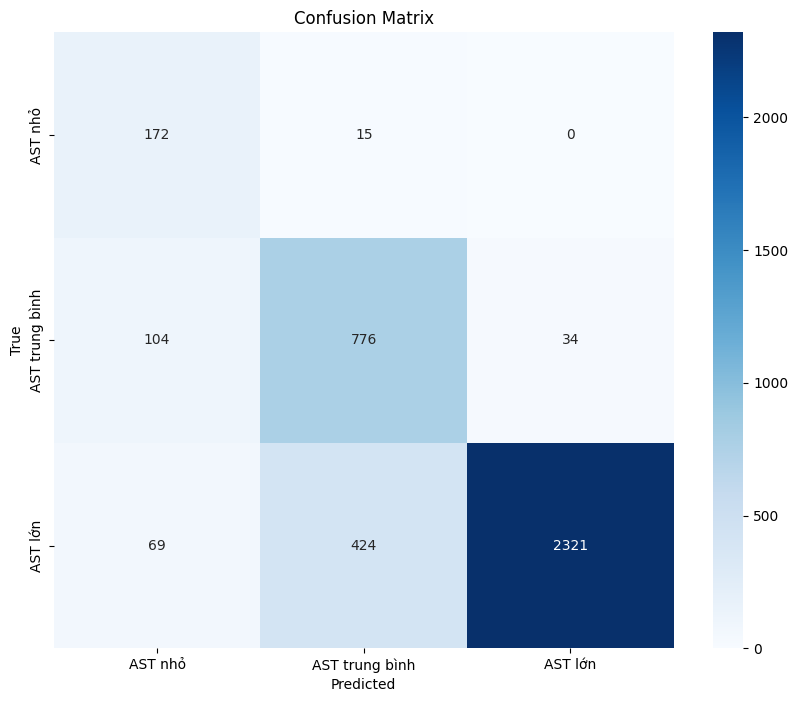

Number of misclassified samples: 646

Analyzing misclassified sample 70:
True label: 2, Predicted label: 1
Number of nodes: 56
Number of edges: 55


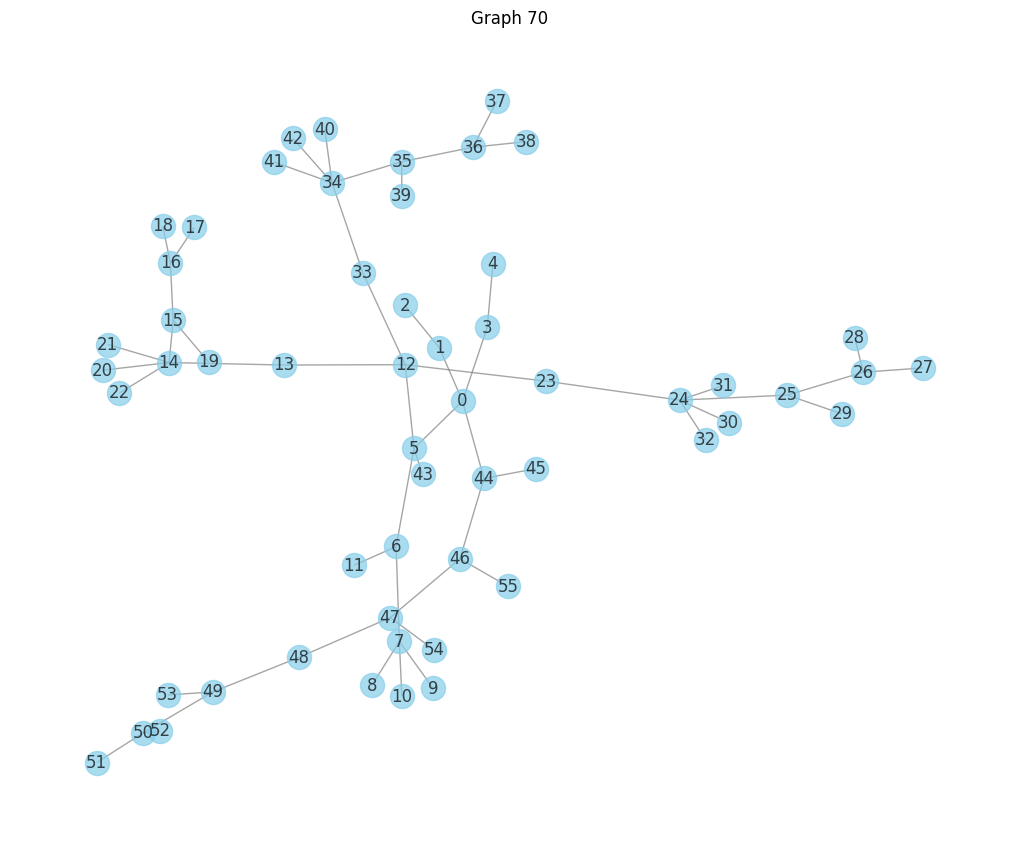

Multi-head attention phát hiện: (97, 4)


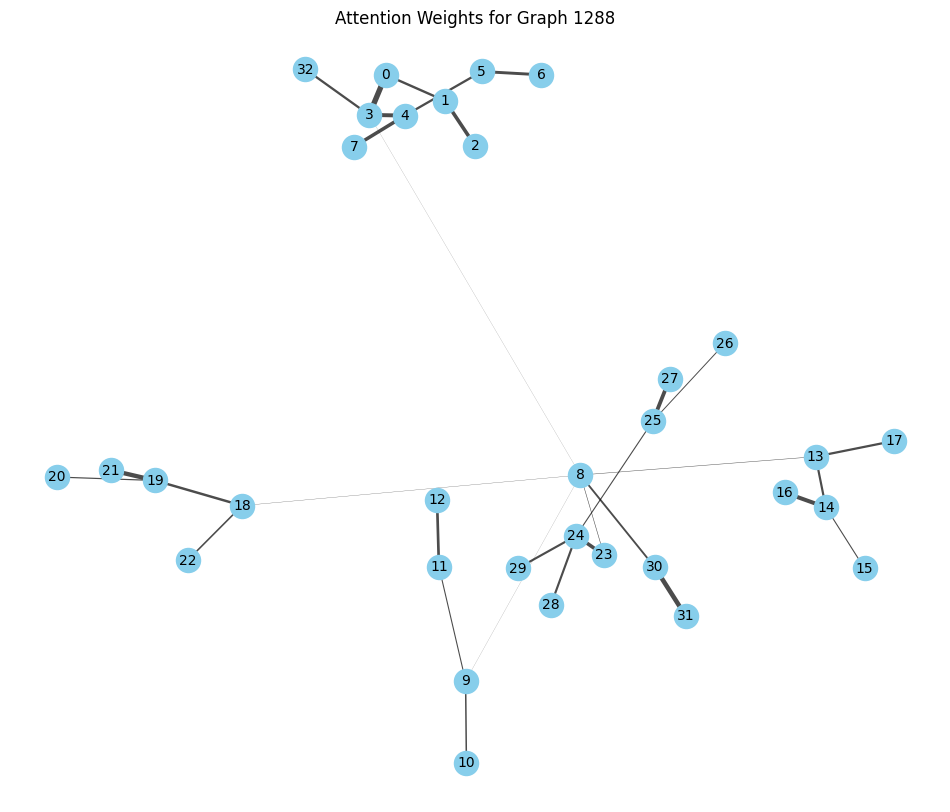


Top 5 edges with highest attention weights:
Edge (25, 26) - Weight: 0.6208
Edge (14, 15) - Weight: 0.6131
Edge (19, 20) - Weight: 0.5991
Edge (18, 22) - Weight: 0.5515
Edge (5, 6) - Weight: 0.5310


In [8]:
# Trực quan hóa đồ thị
def visualize_graph(graph, index):
    import matplotlib.pyplot as plt
    import networkx as nx
    
    # Chuyển đổi từ PyTorch Geometric graph sang NetworkX graph
    G = nx.Graph()
    
    # Thêm các node
    for i in range(graph.num_nodes):
        G.add_node(i)
    
    # Thêm các cạnh
    edge_list = graph.edge_index.cpu().numpy().T
    for src, dst in edge_list:
        G.add_edge(src, dst)
    
    # Vẽ đồ thị
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', 
            node_size=300, edge_color='gray', width=1, alpha=0.7)
    plt.title(f"Graph {index}")
    plt.axis('off')
    plt.show()

# Trực quan hóa ma trận nhầm lẫn
def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Phân tích các dự đoán sai
def analyze_misclassifications(graphs, y_true, y_pred):
    import numpy as np
    
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]
    
    print(f"Number of misclassified samples: {len(misclassified_indices)}")
    
    if misclassified_indices:
        # Chọn một mẫu ngẫu nhiên để phân tích
        sample_idx = np.random.choice(misclassified_indices)
        graph = graphs[sample_idx]
        true_label = y_true[sample_idx]
        pred_label = y_pred[sample_idx]
        
        print(f"\nAnalyzing misclassified sample {sample_idx}:")
        print(f"True label: {true_label}, Predicted label: {pred_label}")
        print(f"Number of nodes: {graph.num_nodes}")
        print(f"Number of edges: {graph.edge_index.size(1) // 2}")
        
        # Trực quan hóa đồ thị
        visualize_graph(graph, sample_idx)

# Phân tích đặc trưng quan trọng bằng attention weights
def analyze_attention_weights(model, graphs, device):
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np
    import torch
    
    model.eval()  # Đặt mô hình ở chế độ evaluation
    
    # Chọn một đồ thị mẫu
    sample_idx = np.random.randint(0, len(graphs))
    graph = graphs[sample_idx].to(device)
    
    # Forward pass để thu thập attention weights
    _ = model(graph)
    
    # Lấy attention weights từ mô hình
    attention_weights = model.attention_weights
    
    if attention_weights is None:
        print("Không thể thu thập attention weights. Đảm bảo mô hình đang ở chế độ evaluation.")
        return
    
    # Chuyển sang numpy để xử lý
    attn_weights = attention_weights.detach().cpu().numpy()
    
    # XỬ LÝ MULTI-HEAD ATTENTION: Lấy trung bình của các heads
    # Kiểm tra nếu attention weights là 2D (nhiều heads)
    if len(attn_weights.shape) > 1 and attn_weights.shape[1] > 1:
        print(f"Multi-head attention phát hiện: {attn_weights.shape}")
        # Lấy trung bình của các heads
        attn_weights = np.mean(attn_weights, axis=1)
    
    # Trực quan hóa
    # Tạo đồ thị networkx
    G = nx.Graph()
    
    # Thêm các node
    for i in range(graph.num_nodes):
        G.add_node(i)
    
    # Thêm các cạnh với trọng số
    edge_list = graph.edge_index.cpu().numpy().T
    
    # Chuẩn hóa attention weights để dễ dàng trực quan hóa
    min_weight = np.min(attn_weights)
    max_weight = np.max(attn_weights)
    if max_weight > min_weight:
        norm_weights = (attn_weights - min_weight) / (max_weight - min_weight)
    else:
        norm_weights = np.ones_like(attn_weights)
    
    # Thêm các cạnh và trọng số
    for i, (src, dst) in enumerate(edge_list):
        if i < len(attn_weights):
            G.add_edge(src, dst, weight=norm_weights[i])
    
    # Vẽ đồ thị
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)
    
    # Vẽ các node
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
    
    # Vẽ các cạnh với độ dày tương ứng với attention weights
    for u, v, w in G.edges(data='weight'):
        if w is not None:
            width = max(w * 5, 0.1)  # Nhân với 5 để nhìn rõ hơn
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=0.7)
    
    # Vẽ nhãn
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    plt.title(f"Attention Weights for Graph {sample_idx}")
    plt.axis('off')
    plt.show()
    
    # Top 5 cạnh có attention cao nhất
    edge_weights = [(u, v, attn_weights[i]) for i, (u, v) in enumerate(edge_list) if i < len(attn_weights)]
    top_edges = sorted(edge_weights, key=lambda x: x[2], reverse=True)[:5]
    
    print("\nTop 5 edges with highest attention weights:")
    for u, v, w in top_edges:
        print(f"Edge ({u}, {v}) - Weight: {w:.4f}")

    return edge_weights

# Nếu có dữ liệu test và mô hình đã được huấn luyện
if 'y_true' in locals() and 'y_pred' in locals() and len(y_true) > 0:
    # Trực quan hóa ma trận nhầm lẫn
    classes = ['AST nhỏ', 'AST trung bình', 'AST lớn']
    plot_confusion_matrix(y_true, y_pred, classes)
    
    # Phân tích các dự đoán sai
    analyze_misclassifications(eval_graphs, y_true, y_pred)
    
    # Phân tích attention weights
    try:
        analyze_attention_weights(model, eval_graphs, device)
    except Exception as e:
        print(f"Error analyzing attention weights: {e}")
else:
    print("No predictions available for analysis.")